by: Artyom Kurguzkin (kurg0002)


steps:

Explore the data

Prepare the data

Summurise the data
- are there any data clusters?

Make models and compare them

## Questions

- which prediction model, with which hyperparameters, works best for which label? why you think so?
- predict values for separate Predictions dataset

note, labels must be predicted independently (i.e., you cannot use the value from one label to help you predict the value for another label).

<br>

# Exploring and preparing Data
---

## Overview

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# note, the location of the data file may very, so you have to change the path to fit your work setup
df = pd.read_csv('work/GameData.csv')
df.shape

(403, 386)

In [37]:
unique_counts = df.iloc[:, -5:].nunique()

print(unique_counts)

Category        6
Region         21
OriginYear    165
BestAgent       6
UCT           122
dtype: int64


In [39]:
# List the unique values in the fourth-to-last column
unique_values = df.iloc[:, -5].unique()

print(unique_values)

['Race' 'War' 'Hunt' 'Sow' 'Space' 'Puzzle']


In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)     # Show all rows (if needed)

df.head(5)

,GameName,String_java.lang.String,Off_int,End_int,int_int,Undefined_int,Piece_game.equipment.component.Piece,Board_game.equipment.container.board.Board,MancalaBoard_game.equipment.container.board.custom.MancalaBoard,Track_game.equipment.container.board.Track,Dice_game.equipment.container.other.Dice,Hand_game.equipment.container.other.Hand,Equipment_game.equipment.Equipment,Map_game.equipment.other.Map,Regions_game.equipment.other.Regions,All_game.functions.booleans.all.All,Can_game.functions.booleans.can.Can,Is_game.functions.booleans.is.Is,And_game.functions.booleans.math.And,Equals_game.functions.booleans.math.Equals,Ge_game.functions.booleans.math.Ge,Gt_game.functions.booleans.math.Gt,If_game.functions.booleans.math.If,Le_game.functions.booleans.math.Le,Lt_game.functions.booleans.math.Lt,Not_game.functions.booleans.math.Not,NotEqual_game.functions.booleans.math.NotEqual,Or_game.functions.booleans.math.Or,No_game.functions.booleans.no.No,Was_game.functions.booleans.was.Was,Mul_game.functions.dim.math.Mul,Difference_game.functions.directions.Difference,Directions_game.functions.directions.Directions,If_game.functions.directions.If,Div_game.functions.floats.math.Div,Mul_game.functions.floats.math.Mul,Sub_game.functions.floats.math.Sub,Square_game.functions.graph.generators.basis.square.Square,Tri_game.functions.graph.generators.basis.tri.Tri,Concentric_game.functions.graph.generators.shape.concentric.Concentric,Rectangle_game.functions.graph.generators.shape.Rectangle,Regular_game.functions.graph.generators.shape.Regular,Repeat_game.functions.graph.generators.shape.Repeat,Spiral_game.functions.graph.generators.shape.Spiral,Wedge_game.functions.graph.generators.shape.Wedge,Add_game.functions.graph.operators.Add,Hole_game.functions.graph.operators.Hole,MakeFaces_game.functions.graph.operators.MakeFaces,Merge_game.functions.graph.operators.Merge,Remove_game.functions.graph.operators.Remove,Rotate_game.functions.graph.operators.Rotate,Scale_game.functions.graph.operators.Scale,Shift_game.functions.graph.operators.Shift,SplitCrossings_game.functions.graph.operators.SplitCrossings,Array_game.functions.intArray.array.Array,Results_game.functions.intArray.math.Results,Union_game.functions.intArray.math.Union,Values_game.functions.intArray.values.Values,Ahead_game.functions.ints.board.Ahead,CentrePoint_game.functions.ints.board.CentrePoint,Column_game.functions.ints.board.Column,Coord_game.functions.ints.board.Coord,HandSite_game.functions.ints.board.HandSite,Id_game.functions.ints.board.Id,MapEntry_game.functions.ints.board.MapEntry,RegionSite_game.functions.ints.board.RegionSite,Row_game.functions.ints.board.Row,Where_game.functions.ints.board.where.Where,Count_game.functions.ints.count.Count,Face_game.functions.ints.dice.Face,Between_game.functions.ints.iterator.Between,From_game.functions.ints.iterator.From,Level_game.functions.ints.iterator.Level,Pips_game.functions.ints.iterator.Pips,Player_game.functions.ints.iterator.Player,Site_game.functions.ints.iterator.Site,To_game.functions.ints.iterator.To,Last_game.functions.ints.last.Last,Add_game.functions.ints.math.Add,Div_game.functions.ints.math.Div,If_game.functions.ints.math.If,Max_game.functions.ints.math.Max,Min_game.functions.ints.math.Min,Mod_game.functions.ints.math.Mod,Mul_game.functions.ints.math.Mul,Sub_game.functions.ints.math.Sub,Size_game.functions.ints.size.Size,TopLevel_game.functions.ints.stacking.TopLevel,Amount_game.functions.ints.state.Amount,Counter_game.functions.ints.state.Counter,Mover_game.functions.ints.state.Mover,Next_game.functions.ints.state.Next,Pot_game.functions.ints.state.Pot,Score_game.functions.ints.state.Score,State_game.functions.ints.state.State,Var_game.functions.ints.state.Var,What_game.functions.ints.state.What,Who_game.functions.ints.state.Who,TrackSite_game.functions.ints.trackSite.TrackSite,Value_game.functions.ints.value.Value,Exact_game.functions.range.math.Exact,Max_game.functions.range.math.Max,Min_game.functions.range.math.Min,Range_

* last 5 collumns: labels to be predicted. Collumns [0-381] - ludemes - game properties. Lots of them seems like binary values.

<br>

In [22]:
# Get the number of unique values for each column
nunique = df.nunique()

# Classify columns based on their unique values and data types
binary_cols = nunique[nunique == 2].index.tolist()  # Binary columns with exactly 2 unique values
categorical_cols = nunique[nunique > 2].index.tolist()  # Categorical columns with > 2 unique values
continuous_cols = df.select_dtypes(include=[np.float64, np.float32]).columns.tolist()  # Continuous columns with decimal values

# Print the names of continuous columns and their unique values
if continuous_cols:  # Only proceed if there are continuous columns
    print("\nContinuous Columns and Their Unique Values:")
    for col in continuous_cols:
        unique_values = df[col].unique()
        print(f"{col}: {unique_values}")
else:
    print("No continuous columns found.")

# Track column with minimal number of unique categories for categorical columns
min_categories_col = nunique[categorical_cols].idxmin() if categorical_cols else None
min_categories_count = nunique[categorical_cols].min() if categorical_cols else None

# Track column with minimal range for continuous data
if continuous_cols:  # Only proceed if there are continuous columns
    continuous_ranges = df[continuous_cols].apply(lambda col: col.max() - col.min())
    min_range_col = continuous_ranges.idxmin()
    min_range_value = continuous_ranges.min()
else:
    min_range_col = None
    min_range_value = None

# Count the number of columns for each type
counts = {
    'Binary': len(binary_cols),
    'Categorical': len(categorical_cols),
    'Continuous': len(continuous_cols)
}

print("\nCounts of each data type:")
print(counts)

if min_categories_col is not None:
    print(f"\nColumn with minimum unique categories: {min_categories_col} ({min_categories_count} categories)")
else:
    print("\nNo categorical columns found.")

if min_range_col is not None:
    print(f"Column with minimum range: {min_range_col} (range: {min_range_value})")
else:
    print("No continuous columns found.")


Continuous Columns and Their Unique Values:
int_int: [ 18.  nan 203. 116.   7.   4.  10.   6.  39.   2.  92.  43.   3.]
Board_game.equipment.container.board.Board: [ 1. nan  0.]
Equipment_game.equipment.Equipment: [ 1. nan]
To_game.functions.ints.iterator.To: [8.000e+00 2.100e+01 1.500e+01 0.000e+00 3.000e+00 2.300e+01 6.800e+01
 8.400e+01 2.000e+00 9.000e+00 1.000e+01 4.000e+00 5.000e+00 1.600e+01
 1.000e+00 1.200e+01 6.000e+00 7.000e+00 1.800e+01 3.200e+01 2.000e+01
 1.700e+01 1.400e+01 1.300e+01 2.800e+01 2.200e+01 1.900e+01 6.600e+01
 2.500e+01 3.400e+01       nan 5.200e+01 1.100e+01 3.100e+01 1.353e+03
 3.800e+01 1.690e+02 9.200e+01 4.600e+01 7.310e+02]
UCT: [ 64.          43.          41.          53.          72.
  54.          55.5         47.5         49.          35.
  40.5         47.          48.5         49.5         70.
  72.5         76.5         79.          60.          38.
  37.5         36.5         30.5         58.5         68.
  51.          71.          46.75    

We need to ascertain that there are any actual continuous data, not descrete ones.

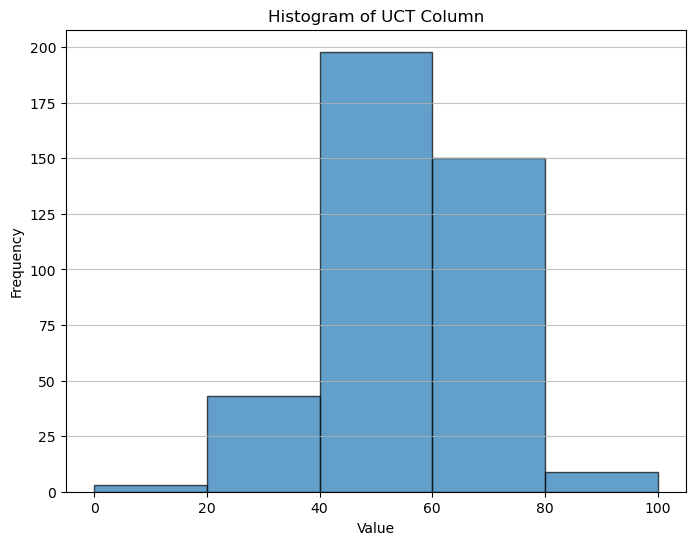

In [22]:
uct_data = df['UCT'].dropna()

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(uct_data, bins=5, edgecolor='black', alpha=0.7)
plt.title('Histogram of UCT Column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The only collumn that is continuous is UCT. Now we need to deal with potential NA values.

In [24]:
for col in df.columns:
    # Count NA values
    na_count = df[col].isna().sum()
    total_count = df[col].shape[0]
    na_percentage = (na_count / total_count) * 100

    if na_percentage > 40:
        # Drop the column if NA percentage is more than 40%
        df.drop(col, axis=1, inplace=True)
        print(f"Dropped column: {col} (NA percentage: {na_percentage:.2f}%)")
    elif na_count > 0:  # Check if there are any NA values to substitute
        # Substitute NA with the most popular value (mode)
        most_common_value = df[col].mode()[0] if not df[col].mode().empty else np.nan
        substituted_count = df[col].isna().sum()  # Count before substitution
        
        # Fill NA and assign back to the column to avoid warning
        df[col] = df[col].fillna(most_common_value)
        
        substituted_count -= df[col].isna().sum()  # Count after substitution
        print(f"Column: {col}, substituted {substituted_count} NA(s) with: {most_common_value}")

---

# Modelling

In [29]:
numeric_features = df.iloc[:, 1:-5]
labels = last_five_cols = df.iloc[:, -5:]
labels

,Category,Region,OriginYear,BestAgent,UCT
0,Race,Northern Africa,-2970,Progressive History,64.0
1,War,Northern Africa,-180,Alpha-Beta,43.0
2,Race,Northern Africa,-100,Alpha-Beta,41.0
3,War,Northern Africa,-3300,MAST,53.0
4,Race,Northern Africa,-2300,MAST,72.0
...,...,...,...,...,...
398,Space,Southeastern Asia,1959,UCT,68.5
399,Space,Eastern Asia,1959,Alpha-Beta,70.0
400,Space,Southern Europe,1949,UCT,69.5
401,Puzzle,Eastern Asia,2019,UCT,100.0


Explained variance ratio: [0.86052396 0.09108223]


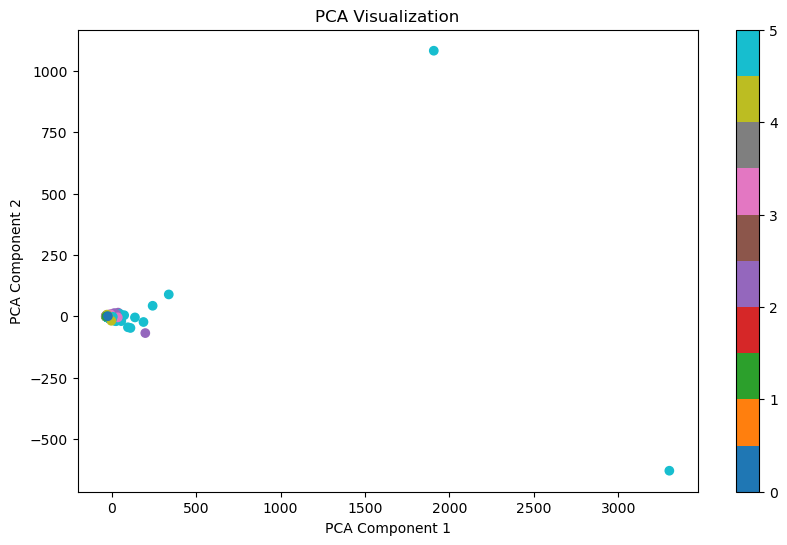

In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Choose one of the last five columns for coloring (e.g., the second to last)
label_column = labels.iloc[:, -5]  # Change this to choose the desired label

# Encode the labels if they are categorical
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_column)

# Run PCA
pca = PCA(n_components=2, random_state=42)
X_digits_pca = pca.fit_transform(numeric_features)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X_digits_pca[:, 0], X_digits_pca[:, 1], c=encoded_labels, cmap='tab10')
plt.colorbar()
plt.title('PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

Original number of points: 403
Number of points after removing outliers: 325


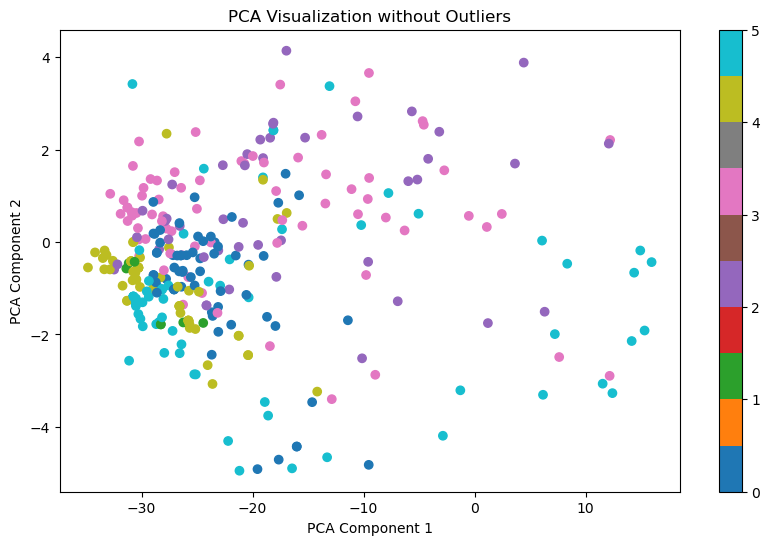

In [41]:
# Run PCA
pca = PCA(n_components=2, random_state=42)
X_digits_pca = pca.fit_transform(numeric_features)

# Convert PCA results to DataFrame for easier handling
pca_df = pd.DataFrame(X_digits_pca, columns=['PCA1', 'PCA2'])

# Calculate IQR for PCA components
Q1 = pca_df[['PCA1', 'PCA2']].quantile(0.25)
Q3 = pca_df[['PCA1', 'PCA2']].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_pca_df = pca_df[
    (pca_df['PCA1'] >= lower_bound['PCA1']) & (pca_df['PCA1'] <= upper_bound['PCA1']) &
    (pca_df['PCA2'] >= lower_bound['PCA2']) & (pca_df['PCA2'] <= upper_bound['PCA2'])
]

# Filter corresponding labels
filtered_labels = encoded_labels[filtered_pca_df.index]

# Print the number of points before and after removing outliers
print("Original number of points:", pca_df.shape[0])
print("Number of points after removing outliers:", filtered_pca_df.shape[0])

# Plotting the results without outliers
plt.figure(figsize=(10, 6))
plt.scatter(filtered_pca_df['PCA1'], filtered_pca_df['PCA2'], c=filtered_labels, cmap='tab10')
plt.colorbar()
plt.title('PCA Visualization without Outliers')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_digits_tsne[:, 0], X_digits_tsne[:, 1], c=encoded_labels, cmap='tab10')
plt.colorbar()
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()